In [1]:
%cd ..

/home/pablo/long-transformers


In [2]:
# add the project root to the python path
import sys
sys.path.append('.')

In [3]:
import pandas as pd
import seaborn as sns

## Listops

In [16]:
df = pd.read_csv("datasets/lra_release/listops-1000/basic_train.tsv", sep="\t")

In [17]:
df

,Source,Target
0,( ( ( ( ( ( ( ( ( ( [MIN 1 ) ( ( ( ( ( ( ( ( [...,1
1,( ( ( ( ( ( ( ( ( ( [MAX 1 ) 8 ) 3 ) 0 ) 0 ) 9...,9
2,( ( ( ( ( [SM 2 ) ( ( ( ( ( ( ( [MED 6 ) ( ( (...,4
3,( ( ( ( ( ( ( ( ( ( ( [MED 9 ) 1 ) 2 ) 1 ) 8 )...,3
4,( ( ( ( ( [MIN ( ( ( ( ( ( [MIN 3 ) ( ( ( [SM ...,0
...,...,...
95995,( ( ( ( ( ( ( ( ( [SM ( ( ( ( [MED 5 ) ( ( ( (...,6
95996,( ( ( ( ( ( ( ( ( ( [MIN 5 ) 9 ) 0 ) ( ( ( ( (...,0
95997,( ( ( ( ( ( ( [MED 8 ) ( ( ( ( ( ( ( ( [MAX 7 ...,6
95998,( ( ( ( ( ( ( ( ( [MED 6 ) ( ( ( ( ( ( ( ( ( (...,4


In [18]:
len(df)

96000

In [19]:
lengths = []
tokens = set()
cnt = 0
for txt in df["Source"]:
    new_tokens = txt.split()
    tokens.update(new_tokens)
    l = len(new_tokens)
    lengths.append(l)
    if l > 2048:
        cnt += 1
print(cnt)

74096


<Axes: ylabel='Density'>

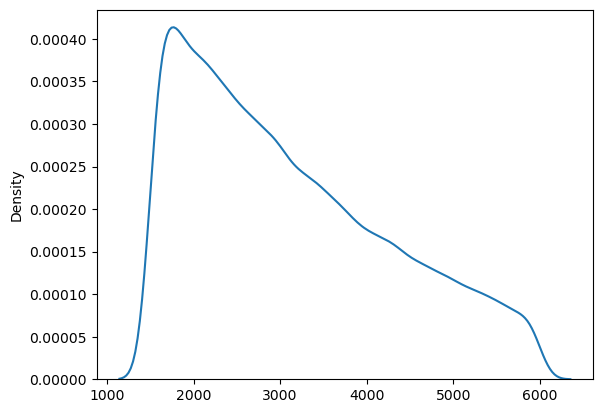

In [20]:
sns.kdeplot(lengths)

In [15]:
len(tokens)

17

## Text classification

In [4]:
from src.data_loaders.text_classification import TextClassificationDataset

/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ds = TextClassificationDataset("datasets/aclImdb", "train")

In [15]:
sizes = []
cnt = 0
for idx in range(len(ds)):
    l = len(ds[idx]["text"])
    sizes.append(l)
    if l > 3000:
        cnt += 1


<Axes: ylabel='Density'>

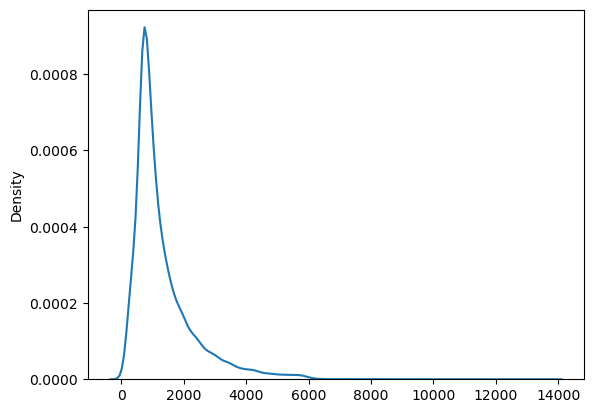

In [16]:
sns.kdeplot(sizes)

In [17]:
cnt

1813

In [14]:
len(ds)

25000